## Setup evnironment

In [6]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from glob import glob
import json
import mvranalysis as mvr

## Setup plotting

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
#import seaborn as sns
#sns.set_context('paper')
#sns.set_style('ticks')

In [8]:
path = '/Volumes/freeman/Nick/mVR/sessions/000076'
session = mvr.load_session(path)

In [9]:
maze = mvr.loadMazeMat(path+'/behavior')

OneChoiceLcts.mat


In [10]:
#session.to_csv(path + '/behavior/session.csv')

#### Create trial summary

In [11]:
trial = session[['trialType','number']].groupby(['number'], sort=True).first()
trial = trial.join(session[['reward','number','rEnd','lEnd']].groupby(['number'], sort=True).max())

In [12]:
#Returns table of all trials and whether or not they entered a specific branch
def trialEntered(branchId):
    keep = session[['curBranchId','number']].groupby(['number'], sort=True).agg(lambda x : branchId in x.values)
    return keep

## Plot data

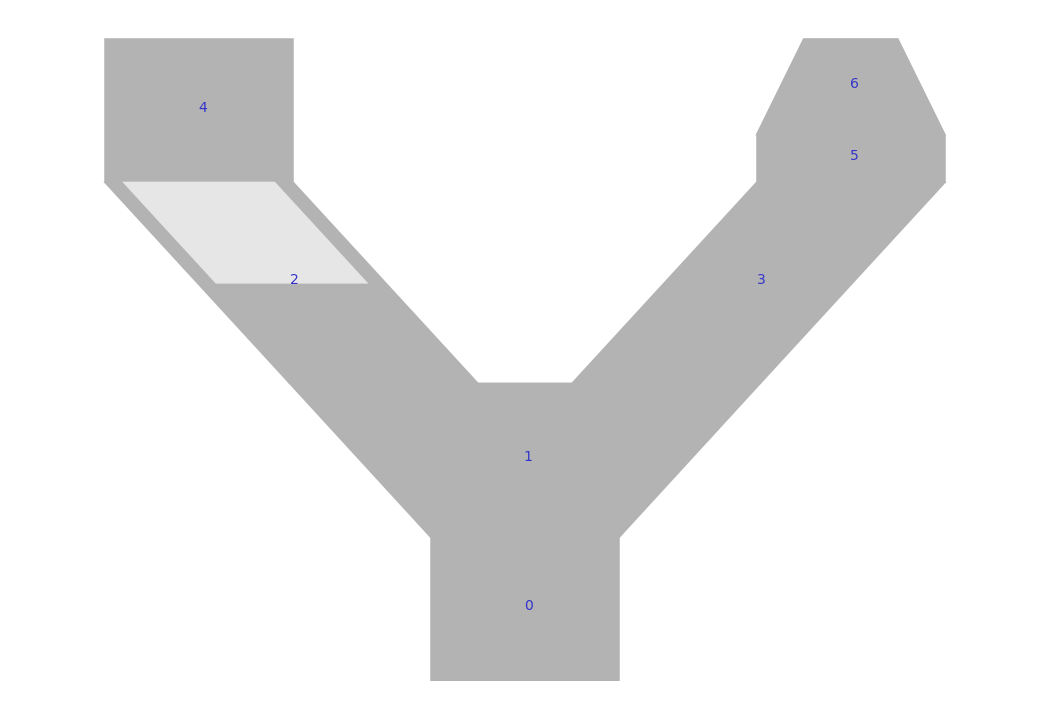

In [13]:
plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)

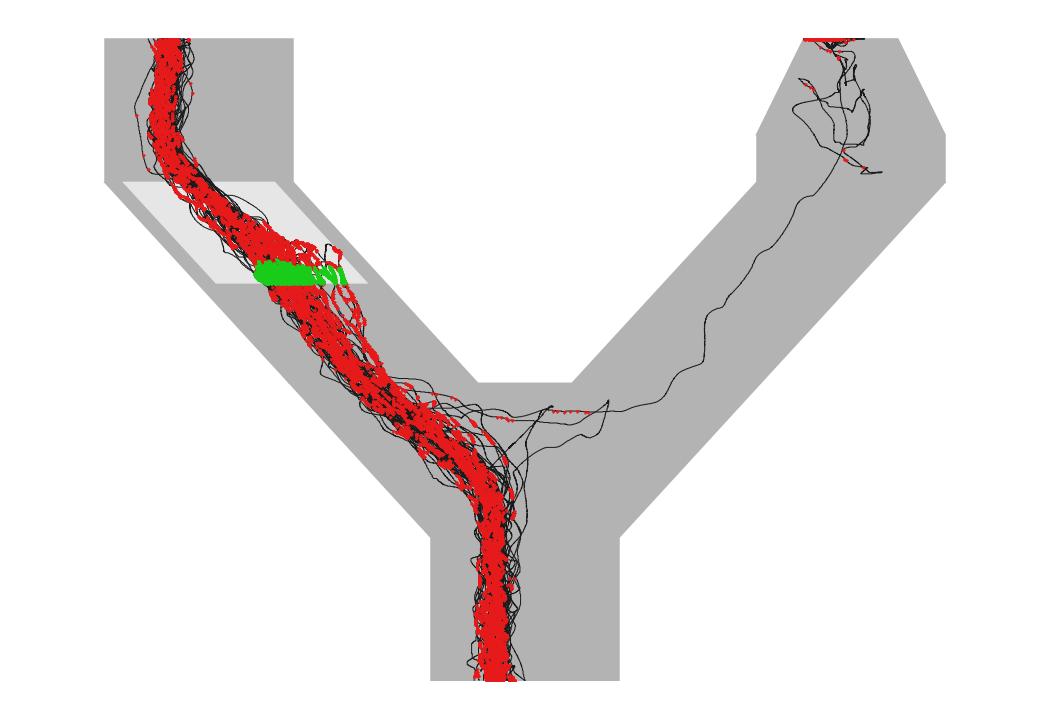

In [14]:
plt.figure(figsize=[18,12])
Id = 0
keep = trial[trial.trialType == Id].index.tolist()
mvr.draw(maze[Id],False)
mvr.trace(session, keep, [0.1, 0.1, 0.1])
mvr.licks(session, keep, [0.9, 0.1, 0.1])
mvr.water(session, keep, [0.1, 0.8, 0.1])

1
0
80


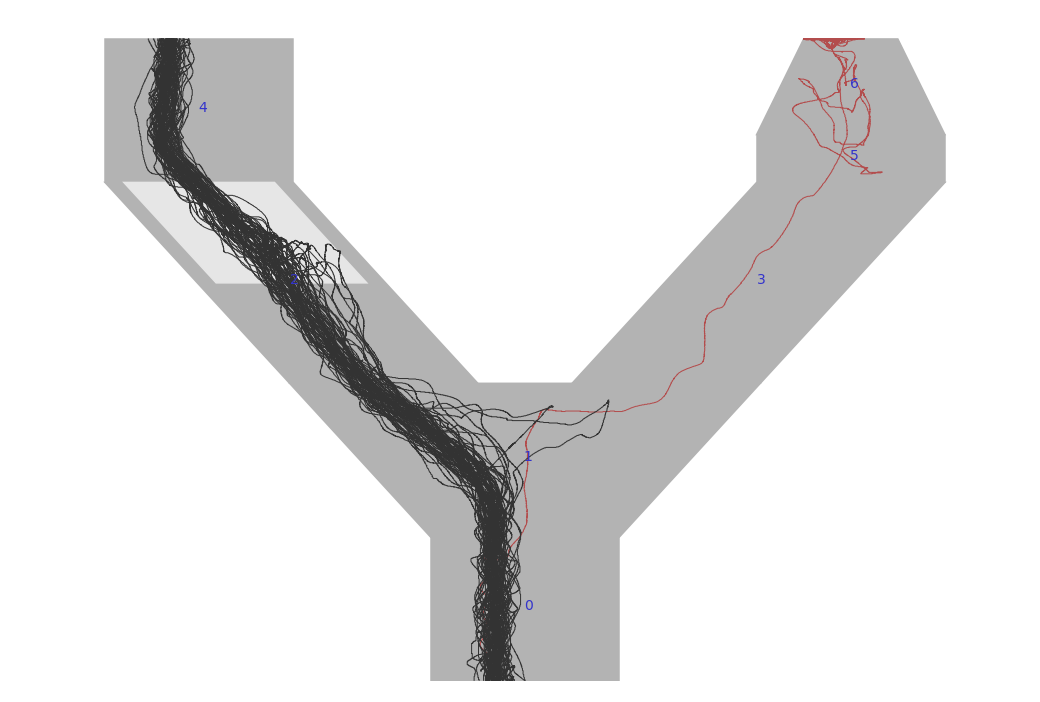

In [15]:
#For the Anti-bias maze (left or right)

plt.figure(figsize=[18,12])
Id = 0
mvr.draw(maze[Id],True)
branchId = 5 #dead end regardless of maze
keepE = trialEntered(branchId)

if maze[0].get('name') == 'OneChoiceLcts.mat':
    branchId = 3 #antibias left
else:
    branchId = 2 #antibias right

keepW = trialEntered(branchId)


keepI = trial[(keepW.curBranchId == True) & (keepE.curBranchId == True) & (trial.trialType == Id)].index.tolist()
print len(keepI)
mvr.trace(session, keepI, [0.7, 0.3, 0.3]) #incorrect
keepS = trial[(keepW.curBranchId == True) & (keepE.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keepS)
mvr.trace(session, keepS, [0.3, 0.7, 0.3]) #entered 3 but corrected itself
keepC = trial[(keepW.curBranchId == False) & (trial.trialType == Id)].index.tolist()
print len(keepC)
mvr.trace(session, keepC, [0.2, 0.2, 0.2]) #correct

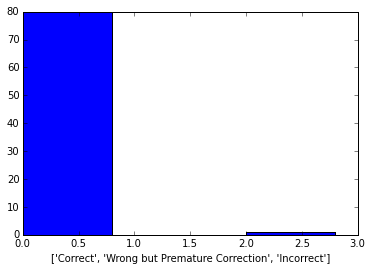

In [16]:
classified = [len(keepC), len(keepS),len(keepI)]
numtrls = sum(classified)
plt.bar(range(0,len(classified)),classified)
plt.xlabel(['Correct', 'Wrong but Premature Correction', 'Incorrect'])

# Create dot plot

([<matplotlib.axis.YTick at 0x10d5b0090>,
 <a list of 2 Text yticklabel objects>)

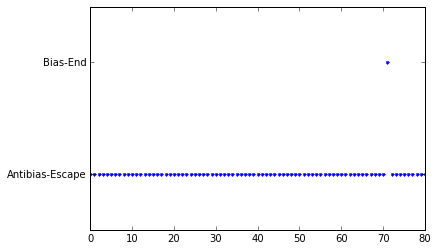

In [28]:
plt.plot(trialEntered(6),'.')
plt.ylim((-0.5,1.5))
plt.yticks([0,1],['Antibias-Escape','Bias-End'])
#in which 1 = left and 0 = right

In [18]:
#Classified into array

def init_choice(numtrials):    
    choices = ["" for x in range(numtrials)]

    for x in range(len(choices)):
        if maze[0].get('name') == 'OneChoiceLcts.mat':
            if x in keepI:
                choices[x] = "R"
            elif x in keepS:
                choices[x] = "RL"
            else:
                choices[x] = "L"
        else: # ANTIBIAS RIGHT
            if x in keepI:
                choices[x] = "L"
            elif x in keepS:
                choices[x] = "LR"
            else:
                choices[x] = "R"
    return choices
choices = init_choice(numtrls)
trial ['Trajectory'] = choices
trial['initChoice']   = [x[:1] for x in choices] 
#print trial

In [19]:
def dead_end(numtrials):
    end = trialEntered(6)             
    return end

deadends = dead_end(numtrls)
trial['deadEnd'] = deadends
#print trial

In [20]:
#Total bias split, based on initial choices

percent_correct = len(keepC)/float(numtrls)
percent_wrong = (len(keepS)+len(keepI))/float(numtrls)
percent_qswitch = len(keepS)/float(numtrls)

print percent_correct,percent_wrong, percent_qswitch

0.987654320988 0.0123456790123 0.0


In [21]:
def completion(session, numtrials):
    finish = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        if (stop-start) > 119:
            entry = False
        else:
            entry = True
        finish.append(entry)
    return finish

complete = completion(session,numtrls)
#print len(complete)
#print numtrls
trial['Completed'] = complete

incomplete = complete.count(False)
percent_unfin = incomplete/float(len(complete))
print incomplete,percent_unfin


2 0.0246913580247


In [22]:
def trial_time(session, numtrials):
    seconds = []
    for n in range(numtrials):
        start = session.time[session.number==n].min()
        stop = session.time[session.number==n].max()
        seconds.append(stop-start)
    return seconds    
        
times = trial_time(session,numtrls)

trial['time'] = times
#print trial

In [23]:
def choice_time(session,numtrials):
    think = []
    straight = []
    choicept = 1
    entrance = 0
    
    for n in range(numtrials):
        start1 = session[session.number==n].time[session.curBranchId == choicept].min()
        stop1 = session[session.number==n].time[session.curBranchId == choicept].max()
        start0 = session[session.number==n].time[session.curBranchId == entrance].min()
        stop0 = session[session.number==n].time[session.curBranchId == entrance].max()
        think.append(stop1-start1)
        straight.append(stop0-start0)
    return think,straight

t_choosing,t_straight = choice_time(session,numtrls)
trial['timeChoice'] = t_choosing
trial['timeStraight'] = t_straight
#print trial

In [24]:
newfolder = path+'/summary'

In [25]:
os.mkdir(newfolder)

OSError: [Errno 17] File exists: '/Volumes/freeman/Nick/mVR/sessions/000076/summary'

In [ ]:
trial.to_csv(newfolder + '/trial_summary76.csv')